In [16]:
!pip install matplotlib seaborn
!pip install schedule


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from algosdk.v2client import algod, indexer
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import schedule
import time
from IPython.display import clear_output

# Algorand Whale Tracker

Este código implementa un sistema de análisis para monitorear y evaluar la influencia de las carteras más importantes (whales) en la red Algorand. El sistema calcula un score de influencia basado en dos métricas principales:

1. Actividad Transaccional (40% del score final):
   - Volumen de transacciones
   - Frecuencia de operaciones
   - Tamaño máximo de transacciones individuales

2. Holdings (60% del score final):
   - Balance de ALGO
   - Diversidad de ASAs en cartera
   - Cantidad total de activos

El score final se normaliza entre 0 y 1, donde 1 representa la máxima influencia. El sistema permite monitoreo continuo con intervalos configurables y exporta los resultados a archivos CSV con timestamp para análisis histórico.

## Requisitos
- Conexión a nodos Algorand (usando algonode.cloud)
- Lista de direcciones a monitorear
- Python 3.x con py-algorand-sdk

## Características
- Análisis automatizado de transacciones
- Evaluación de holdings
- Normalización de métricas
- Exportación de datos
- Monitoreo configurable
- Manejo de rate limiting
- Sistema de scoring ponderado

Los resultados permiten identificar patrones de comportamiento, concentración de activos y niveles de actividad de las wallets más influyentes en el ecosistema Algorand.

In [13]:
class AlgorandWhaleTracker:
    def __init__(self, algod_token: str, algod_address: str, indexer_token: str, indexer_address: str, whale_addresses: list):
        self.algod_client = algod.AlgodClient(algod_token, algod_address)
        self.indexer_client = indexer.IndexerClient(indexer_token, indexer_address)
        self.whale_addresses = whale_addresses
        
    def analyze_transactions(self, days_back: int = 30) -> pd.DataFrame:
        import time
        """Analiza patrones de transacciones."""
        start_time = (datetime.now() - timedelta(days=days_back)).strftime("%Y-%m-%dT%H:%M:%SZ")
        tx_data = []
        
        for address in self.whale_addresses:
            try:
                response = self.indexer_client.search_transactions(
                address=address,
                start_time=start_time
            )
            
                txns = response.get('transactions', [])
            except Exception as e:
                print(f"Error procesando {address}: {str(e)}")
                txns = []
                time.sleep(1)  # Rate limiting
            daily_volumes = self._process_transactions(txns)
            
            tx_data.append({
                'address': address,
                'avg_daily_volume': np.mean(daily_volumes) if daily_volumes else 0,
                'max_single_tx': max(daily_volumes) if daily_volumes else 0,
                'total_volume': sum(daily_volumes),
                'transaction_count': len(daily_volumes)
            })
        
        return pd.DataFrame(tx_data)

    def get_asset_holdings(self) -> pd.DataFrame:
        """Analiza holdings de ASAs."""
        holdings_data = []
        
        for address in self.whale_addresses:
            account_info = self.algod_client.account_info(address)
            assets = account_info.get('assets', [])
            
            holdings_data.append({
                'address': address,
                'algo_balance': account_info.get('amount', 0),
                'asset_count': len(assets),
                'assets': {asset['asset-id']: asset['amount'] for asset in assets}
            })
            
        return pd.DataFrame(holdings_data)

    def calculate_influence_score(self) -> pd.DataFrame:
        """Calcula score de influencia."""
        transactions = self.analyze_transactions()
        holdings = self.get_asset_holdings()
        
        scores = pd.DataFrame()
        scores['address'] = self.whale_addresses
        scores['transaction_weight'] = self._normalize(transactions['total_volume'])
        scores['holdings_weight'] = self._normalize(holdings['algo_balance'])
        
        scores['influence_score'] = (
            scores['transaction_weight'] * 0.4 +
            scores['holdings_weight'] * 0.6
        )
        
        return scores.sort_values('influence_score', ascending=False)

    def _normalize(self, series: pd.Series) -> pd.Series:
        """Normaliza valores entre 0 y 1."""
        min_val = series.min()
        max_val = series.max()
        if min_val == max_val:
            return pd.Series([1] * len(series))
        return (series - min_val) / (max_val - min_val)

    def _process_transactions(self, txns: list) -> list:
        """Procesa transacciones para análisis."""
        volumes = []
        for tx in txns:
            if tx.get('tx-type') == 'pay':
                payment = tx.get('payment-transaction', {})
                if payment:
                    volumes.append(payment.get('amount', 0))
        return volumes

# Ejemplo de uso
def main():
    # Configuración de clientes
    algod_token = ""
    algod_address = "https://mainnet-api.algonode.cloud"
    indexer_token = ""
    indexer_address = "https://mainnet-idx.algonode.cloud"
    
    # Lista de wallets a analizar
    whale_addresses = [
        "N2C374IRX7HEX2YEQWJBTRSVRHRUV4ZSF76S54WV4COTHRUNYRCI47R3WU",
        "MTCEM5YJJSYGW2RCXYXGE4SXLSPUUEJKQAWG2GUX6CNN72KQ3XPJCM6NOI",
        "NE5EGI4JA5EFJV3AVD4OPYNBJYN66ZKOWKOXADZKZMZ3DFGQGY3VEKHMFU",
        "FB3ILSDVDSECHNC25SZCOCQVKVQC27MF54S42KQ2H7THP7MU2WEBNDJYJY",
        "HEOQ3S6V47RFLU2RZ5GTQYJBEFRL54UWZ77PNUBNTDVSXIPYOPE2XZJSLE",
        "J63NZUR3S4LJC2RPBSOXGQ75DUVQEBTIFUWL2R7FCQES24HFLQAFB6WDAY",
        "5P4IEQSZBRAQHE4WQIIMYQGSVD4N6ZWM7TEJ3QXXMZIL4BR3MV6BFQYTUQ",
        "ZDEFFZZ4NAWFP525TOGNWICWOXKOF74DFMYCE6BMMZIZVX5NNPYKN4SRRA",
        "2R5FTTVDIAQ55I5SPW5BE6R2SVYY45O5W64XGIVBLHQYWMZARRXTO4VIHQ",
        "LYKPESAJWNRAV7XADUHBKLADBK47HWKIM4W3K7ICKXXEURMP2AJLYLFDF4",
        "JJT4QS7NTMCKVSLJUZ6BQLV44MLQ4F5OWFJP26CN3BYTPORMMRO5AB6QCA",
        "53B5Q2CMPW2HZDZYKXECOMQGZDWNIT4W75B3D5XAT3ABPDCMCQT6RVHJGI",
        "WZY5ZGJ57YOVJ2TCMFXIH6TNLDC2FI2UJSWGG4XN5RK4XVQX4MMOIZD2AU",
        "BX7UST4VVWQQPPAVPMPFW76QRKXRLQ3UVYABWBTHOAX2AN5Q5OGW2X55AQ",
        "KQ6FVR6PTHMV7QV47LBSR3LVM3EWSNHJPTWQ7GUEFLI2NGKC3RAULQ27K4",
        "DLRY7TLD3KXB4G6IAIW5KGUZEVIDBS2OZ3LR7RFSJD2KEUDKWFXEBPK3HU",
        "WD5EDLJCLRWFIBEUCT43J6QM3LGVNSYXUSMWGUKKUMJBZ65IKQWIAV2LIY",
        "UI6AGNWYGQD6HNQVEZ5ZTAQR27FHZ45VMLTS7LTSF2IZGAJMOIF4V4EEVU",
        "IVBHJFHZWPXRX2EA7AH7Y4UTTBO2AK73XI65OIXDEAEN7VO2IHWXKOKOVM",
        "T6MXHXMGXURKJ7AD5NCB4IYPLWXYXKKFLLO5KAPJ56GKS7BFXHNHOODZCM",
        "FFLRE4VZK35KAU65VLBRMR4KZVHE4S2TEXJJ6K4POZJZXUND3V2V6DVJNU",
        "5GW5VO4JNTHXVH2DYV7HAKBKGQFSCAI4MBUD5EN3FLBGLF4KKRXJE24ASI",
        "3SORALOCWWTHAAGEZIOB5MIV2G3KAWUN2LQI4ZBWPLEDZANPIVTHFHDGZ4",
        "ZVMOZVZJK64NEYDPUDGGC52NI6HOX2LUQVIWYCQTJ2DFXRGPL72C2BQYNM",
        "2ZPNLKXWCOUJ2ONYWZEIWOUYRXL36VCIBGJ4ZJ2AAGET5SIRTHKSNFDJJ4",
        "GH27QMBSQZF3O6J7SGXQRQMUQD264HNXZ7R6OXDPIOR5XOOE22UBWUXZI4",
        "LRDSA35VTQL3ORSNBCM7TPGMYZKWK3OTRWSKD6NSXOKAOIPHQXJFEKNS2Q",
        "EU6CHYSH7ZXLJQAPPIN6W3KS7VAURYZCB5P3ZCXMYCWNJF6V5RTVL2UPHU",
        "4H5UNRBJ2Q6JENAXQ6HNTGKLKINP4J4VTQBEPK5F3I6RDICMZBPGNH6KD4",
        "TBN2J7U3J5D4I7R2EK7XIBFNTEGVLHNORAXQ6YBJY5IVNY5IIKOXSJRYCE",
        "L5BLJ4FNK6FNM7V5NUVT5QI6NQAERLLHYT24XH6RS2DUC4WDHPM5LOLGBY",
        "VEJGTLTKNT3VGLG2GVB2LMXC55WYW6J6WPZ76XTY2Y46TRJQOORWERYXYE",
        "XBYLS2E6YI6XXL5BWCAMOA4GTWHXWENZMX5UHXMRNWWUQ7BXCY5WC5TEPA",
        "2JGGWKOIKYZB4HLG2X5DWHD5EWCUOQR7DC6VOEMWELIVNVVAF3BEUWJR7Y",
        "LHVWNRKGGOTSSDYK4P4WKXTHZI5SAFKUO5ALAW7NJ6G76RG4UXLBCWN5LQ",
        "NRDDQ7MFRTUTMDAP4CBXDQ2IVP5VSLKDASADLLANYLFIKR7NQOGOUINYM4",
        "62UUOSMOMD6XOSRROCIIMVVF2VX6N4CMVLCUFUVWV4Q4T4BHD7ETFNWMOI",
        "O4N25TS4Z5SC34VZ6R6RU74PCEIUTJFSDSKETNDYU4CXI3C2BFYXCYEKAU",
        "GJGK42UVZK4IDKN5MGP53A6FJEHRI52PI4E3BBJZRZCQZ666BKYILYXI2E",
        "R3T4HFV3QXOHCZHRSQDJATCI2E7KHFA4BAWG5C6CGS3MGFNUFSI5FAYEN4",
        "VZBMOTCMEHRITULBNLCWHA5U62UUXLQZMLVM6HPBPCMIM2YOMHDQRTK64E",
        "OM2NLTOCWVDGX5XI6ETIQPW2CEILSEJFOC4NX5TJCTU6WMNC2KT2OUCT4M",
        "VAOTJJLJP54QIKGCCFNJZVNHXXFZUZ3AAXCVGX5LRDQXQOUZRWBFBASUDQ",
        "A3MYPLCU5ZVXDJEAXAVV2SAUWJ4INWGPYOKM3FWOGUASOJ7V2L6DTC5YN4",
        "5EYP2467BNWUIE773T57P3VZ5RRMWUFCPSYOOUHVFP4AY5HSZ7MKECKTKI",
        "5WCIZNGQQT747WX3RTQIBJHOMJTQRUQBBH3PMK4YLP2X33AICJEUTL6F2E",
        "R7ALVPEQRGECJK33LANXMPENWYALTAZQTSGNCTEQPKBSBDI5KO252SAK64",
        "P73D4BTS5B55FBV5Q4K2JZNTJOOMACZY4TFYKLCHPCOGLUPGDBXDBVSS7E",
        "YX5KZSZT27L7WZAW7TNONVDZHQQAURJKT4BPRS364KTH2DGMEKLLFOPK3U",
        "IHYR5OZGAIRSCDCNQJVFOPAOJT2SPG3YXAE3GGJPZRI6JV2GQSJAYG5NUY",
        "OFB2SMWDDB3V4RYRSC6EXJYB2RYFVPWGYYEGAOLK52TN72G2DELKVENV44",
        "A66JRYUOU523Z4MU53AJL3YAEHESH3KMVV7OJI4SMFRVIDNNVDK2LHSL4Y",
        "7LXGH4WPEXJ3HOPON5BDHJSJ7NWPBAELDOWLINCMMW2GOQWOSSNP76D4ZA",
        "MKZIWVBDBZV7UK6XQY3DFLYSBLSJWCDHDJWK3JAHWCFMNJOH4ZXQSMOUCE",
        "2JBQSMWAZANNM5U2P2DPCBVJ7VYLRT7LA2AOP7JGUF4HIBV6XBA3TBGXGA",
        "E4VMOYKWJCTKYVY447ALPOZMORITQYQVZVSYJ4ABLCCAAX4ZE6RNFDXZPI",
        "HRLD25IMT2Q4UPYOEUZIWHDI3ELCUIC5NLNC75O2NE7OLDJK7GZXDIK5QQ",
        "EG6JXQ3TQBWRSTR3OEDUS5RTPLMA4KTMJIV3N6DO7XN2XRKIFEN64DY3BU",
        "WDWBXGJIXO3N6A7AZ25XU4UX5Q3FJJ5CCKFCUEUWE75ZF5I6H47X37EY6M",
        "ASHPGJPHCZMSVBBUVFOVTSIYFKCR26STPOVPU4GWACKTZT35ZQYBSE775U",
        "W425PRGCPQFAKWSN7D2QKGKBHUWEVV4Z5PWLKUTIGYULGEU5ZDXOAKETC4",
        "5I7NE6QCQYZUUKKMZ2HLB2AWO7NDUXNKVFACAF46NEP3TA6ZHAYOHIEVMU",
        "7GPQ36Y43EF77SDEMPMGCFIWBT3CRP3U6VMT7SK42X42ZUOXVS7TD3KXAA",
        "WW5MEAVIVE3X4N6ZED4CEXUKAAEBACMS2HSGG7GIOXKHWCWKCAGAWDSGL4",
        "KHGLFYRM52BT6R5CSREB7BNUOSR3FUEHCWLIXKWM44SD2RZMSXDPZS77U4",
        "HMKN4BCGCDUFWIPOIKDBUTC6RXFKOKOB6TWO25ETRHTKJFTJZPD6Y3BOLQ",
        "OTW6HXVSWXDRBV2F7RK5YHYBERVYUYQ4KSVRW5K4ECBONAJBSFHHDSP764",
        "SXNDBVZXTLF6JJVER3VZV5XMGV6SGDNANHATZZIKHWVF5RV2JVPQ7NB56E",
        "7ZUHI3E5Z7V5XJTQISK76KXG4O7KJY66VD7LFIX2EZ5Z5VOVZBONZDAVWM",
        "QYXDGS2XJJT7QNR6EJ2YHNZFONU6ROFM6BKTBNVT63ZXQ5OC6IYSPNDJ4U",
        "XMVGCC27ZCGWKOQYZDE5WESGYS4V7CRTQVIAZETJNNV7U3QTHJ6CUZ62PQ",
        "C4PZ7RSTYDAAEJE3PIMJW3BRYKNY6OHYZVZO6OLXPZKBMXVWDB4PBECTZI",
        "OMHYS6DGAS2GQIMALPYPSMNDQ2735J7Z76RQFH7KP2MIPDHXOZYVV3TVO4",
        "V6F7XZUE6G4ODLE47CY32PLDLEC6LELBE7JWQX6RMBJBPFMZ5UOM3WXMWM",
        "EIATQQ3TAKBR67FOEMPPSOA2ZYXO5FNXQQDUPRFFISS2Y6AO5HMJBFNRXE",
        "JHCVUBWAJHEMNPBZDNYVXK6DNRFUJWNLWXDDLLBOLIL3KFCQAOI3XVMWOA",
        "PZ7TILKNWVGJTAWF7YSBYDHT44SN6NQJXHI55ODGJXGXHGB64BH6MBDGFY",
        "UTFJWM5YP6TSR66YHRYBNDZLCYTTSMLDBKKFTEE723HT7GJBGNCWD6UDC4",
        "SJYNEQ36GVJBQ3YRZTVQGMFQDHRZKK3SGXF224WKNP7S3NAU563RNPUMWA",
        "UPBR75UVEX4UVBKLLXDEVF5OI6SN426G7IEEZFM2QYMXQHPHTX5FZUT2MA",
        "DEK6IBQKSX5JPKUSIDCLRUEXTAJLSEM5EFZWXDDYYVPKBH3JOS4NPT477U",
        "FRWQZO4A6NZKANEYYWAHZIBHJ46T2LVRFACCLHUY3JQAJLUIWNQQLOQ26A",
        "ASDNGCOKPWDF3IFVNGVYTRC4EBU4RGFBIX4PVFMBVUM3T4WIKID5GABY3Y",
        "UFEO4JIEEJD73NJM6FPRD57USABORDHLDBJPBNIZBHB3TJTA6CBNSAPI4E",
        "A6B5AKODYAMHTQ7B4PJAMOLDLZFMAB4QOXJJP6I3FC7YIPOPD6PL7ZYRCA",
        "O4WKNVA25QYYMN3NW534CWE65PPIMU56TNB5ZJIKGOQHBXEFU6QACUJWOQ",
        "P2W7L5OERZ53KV4LJOCV3HR75ZPA6BDLHCAL27IQSIE2WDFGRFEGL524VA",
        "PRNU5BPKXY5G322XPP7D7R7NH7MFFUUO44522T3P5OT64DB56JJ5ZQJ4LA",
        "I63NBAY2FYICKXSF7XFJRUV3CQDB756EDQ245D47Z34LTEFP7JYXS56QTM",
        "3XQ3RJXTG2VDOV45ZKYIGEVXP2VF2HDZJX6I3NUCIJHXGHYEDA74LRSQ5U",
        "LSAH7NBFXSUP2RSNS4UDA6KA3THYIS5CAWVE7IG4N45FAEGQOXYCXSL4TI",
        "C2QRHHR3K7KSLNQV4BJCD6UVM5OJSSXTV2YQR6DOYVL3X7ZGC2BBZRFKEE",
        "ALMEZURUOG7R2QKPZIPNQAFANRQEZU4J22ZJYW6HARU4IZCZGEHNTZMO6U",
        "B2465RWQTTRXELPWRZENQIQLBPDTQQZJGEQXLWQHQTBHUMSD2RKA7CAWEM",
        "B23XLXSA3MBU3SLP5EF2HE7JRR2UMFNKZBIDRWQPGLGCNDNCABWHMDXPMQ",
        "K4F7HD3ZEQZ7SG5XDSXJSC6HVXXCQQQK6E47MRA5ZUJ2I7Y54G4LUZKMUY",
        "ILZP3VLXPZOMULC5XMR5UUL5LMBGXX6TT6IURYFZ7Q6KX54INCUISZH2JQ",
        "22LRYAZSTGCB7DXQUKOWA3JG4ZP2DZJ3H6R5ZCVE5XBIXLK2VPST5CY2J4",
        "3NGBML54PC7AJATJGW5BXMF6ZOFO2V4VTKKRTS3EAZXTVVHSPXTNV2GKEA",
        "XUPBGF6OXIRVIGU2VHHYJFI4JEHLLIPNLMWNCSUZ7F44KYFRPV52ULIYNI"    
    ]
    
    tracker = AlgorandWhaleTracker(
        algod_token,
        algod_address,
        indexer_token,
        indexer_address,
        whale_addresses
    )
    
    influence_scores = tracker.calculate_influence_score()
    influence_scores.to_csv('whale_influence_analysis.csv')
    print("Top 10 wallets más influyentes:")
    print(influence_scores.head(10))

if __name__ == "__main__":
    main()

Top 10 wallets más influyentes:
                                              address  transaction_weight  \
0   N2C374IRX7HEX2YEQWJBTRSVRHRUV4ZSF76S54WV4COTHR...        9.605388e-04   
1   MTCEM5YJJSYGW2RCXYXGE4SXLSPUUEJKQAWG2GUX6CNN72...        5.742853e-02   
25  GH27QMBSQZF3O6J7SGXQRQMUQD264HNXZ7R6OXDPIOR5XO...        1.000000e+00   
73  V6F7XZUE6G4ODLE47CY32PLDLEC6LELBE7JWQX6RMBJBPF...        3.785809e-01   
79  UPBR75UVEX4UVBKLLXDEVF5OI6SN426G7IEEZFM2QYMXQH...        1.301740e-01   
19  T6MXHXMGXURKJ7AD5NCB4IYPLWXYXKKFLLO5KAPJ56GKS7...        2.159313e-01   
64  KHGLFYRM52BT6R5CSREB7BNUOSR3FUEHCWLIXKWM44SD2R...        1.303132e-01   
21  5GW5VO4JNTHXVH2DYV7HAKBKGQFSCAI4MBUD5EN3FLBGLF...        3.791255e-02   
5   J63NZUR3S4LJC2RPBSOXGQ75DUVQEBTIFUWL2R7FCQES24...        2.595770e-12   
6   5P4IEQSZBRAQHE4WQIIMYQGSVD4N6ZWM7TEJ3QXXMZIL4B...        0.000000e+00   

    holdings_weight  influence_score  
0      1.000000e+00         0.600384  
1      8.322130e-01         0.522299  
25 

# Visualización y Análisis Estadístico de Whales

Este código genera visualizaciones y análisis estadístico de los datos recopilados sobre las wallets más influyentes en Algorand. Produce dos gráficos principales:

1. Gráfico de Barras: Muestra los scores de influencia de las top 20 wallets, permitiendo identificar fácilmente las carteras más dominantes.

2. Scatter Plot: Visualiza la relación entre holdings y actividad transaccional, usando un mapa de calor para representar el score de influencia. Ayuda a entender cómo se distribuyen las wallets según estos dos factores.

Adicionalmente, genera estadísticas descriptivas (media, desviación estándar, mínimos, máximos) y matriz de correlación entre las métricas principales. Esto permite entender:
- Distribución de los scores
- Relación entre holdings y transacciones
- Patrones de comportamiento de las whales

Los resultados se muestran tanto visualmente como numéricamente para facilitar diferentes tipos de análisis.

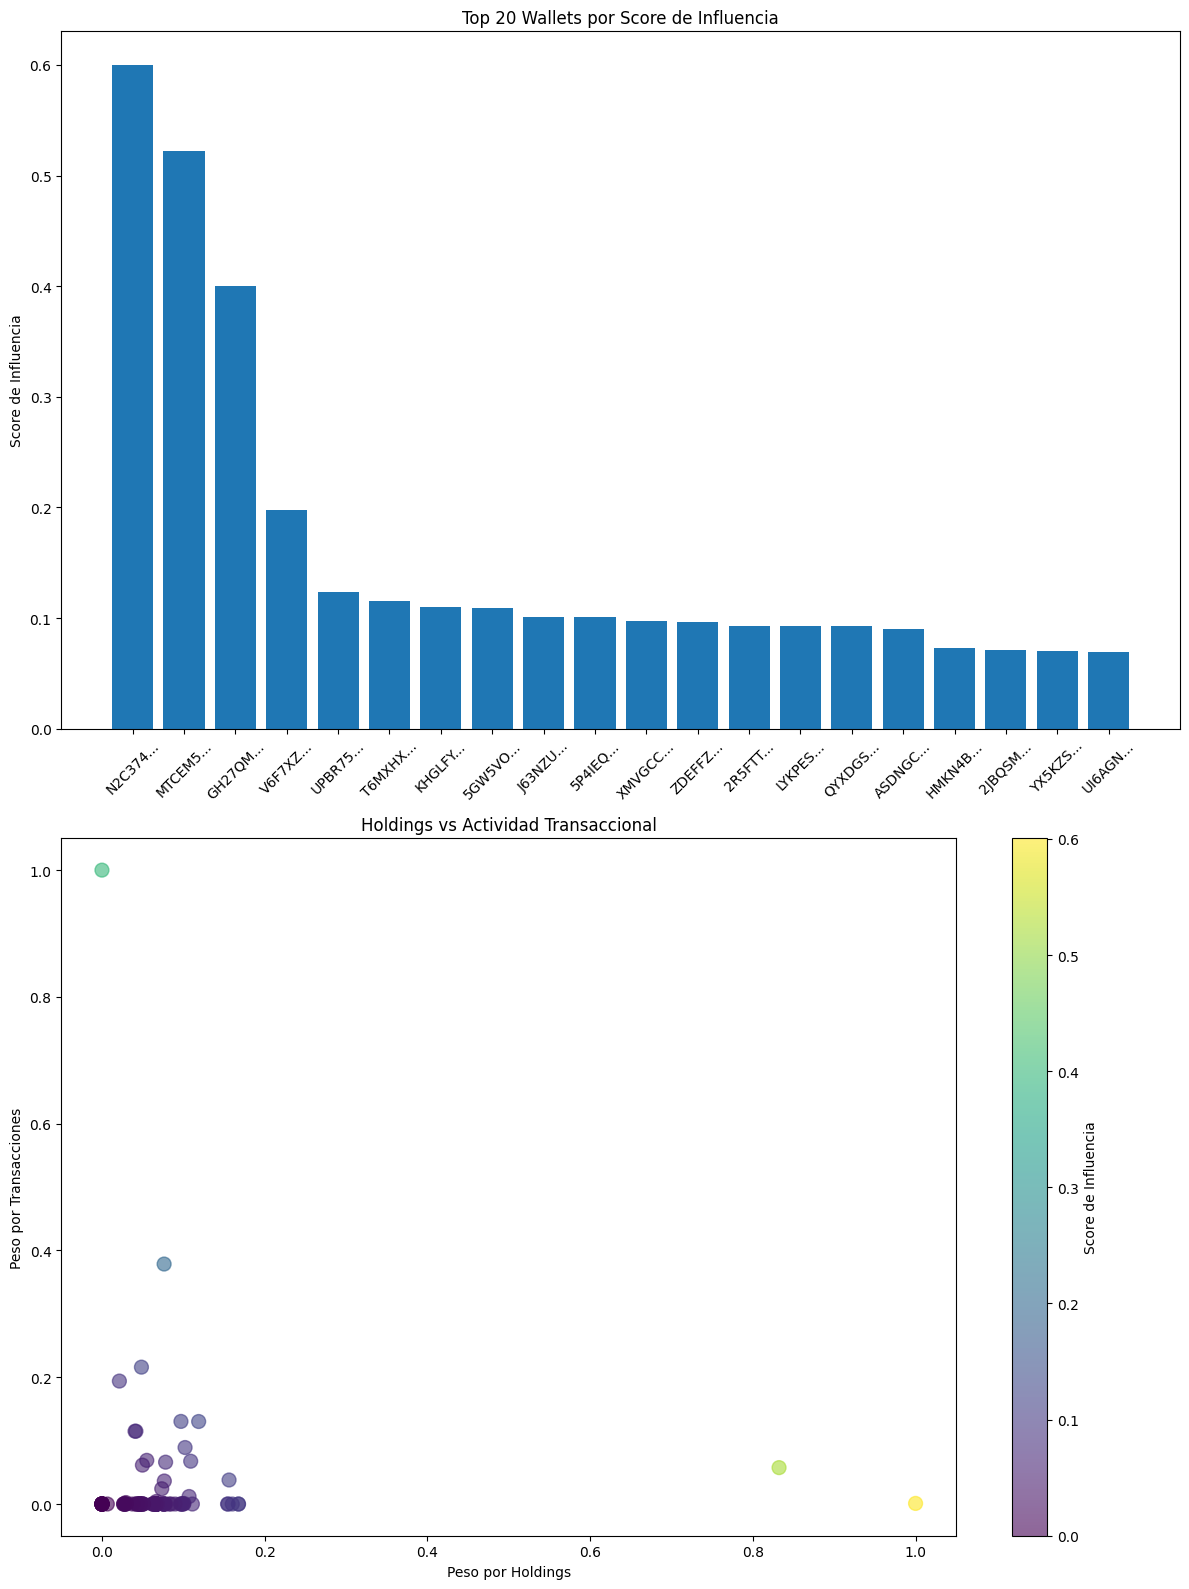


Estadísticas:
       transaction_weight  holdings_weight  influence_score
count        1.000000e+02       100.000000       100.000000
mean         2.807434e-02         0.078433         0.058290
std          1.119724e-01         0.126926         0.086977
min          0.000000e+00         0.000000         0.000000
25%          2.595770e-12         0.041958         0.026983
50%          3.319369e-12         0.065049         0.040402
75%          2.686507e-11         0.077019         0.059650
max          1.000000e+00         1.000000         0.600384

Correlaciones:
                    transaction_weight  holdings_weight  influence_score
transaction_weight            1.000000        -0.035282         0.484060
holdings_weight              -0.035282         1.000000         0.857412
influence_score               0.484060         0.857412         1.000000


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer datos
df = pd.read_csv('whale_influence_analysis.csv')

# Crear subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Top 20 Wallets 
top_20 = df.nlargest(20, 'influence_score')
axes[0].bar(range(len(top_20)), top_20['influence_score'])
axes[0].set_title('Top 20 Wallets por Score de Influencia')
axes[0].set_xticks(range(len(top_20)))
axes[0].set_xticklabels([addr[:6] + '...' for addr in top_20['address']], rotation=45)
axes[0].set_ylabel('Score de Influencia')

# Scatter plot
scatter = axes[1].scatter(df['holdings_weight'], 
                         df['transaction_weight'],
                         c=df['influence_score'],
                         cmap='viridis',
                         s=100,
                         alpha=0.6)
axes[1].set_title('Holdings vs Actividad Transaccional')
axes[1].set_xlabel('Peso por Holdings')
axes[1].set_ylabel('Peso por Transacciones')
plt.colorbar(scatter, ax=axes[1], label='Score de Influencia')

plt.tight_layout()
plt.show()

# Estadísticas
print("\nEstadísticas:")
print(df[['transaction_weight', 'holdings_weight', 'influence_score']].describe())

print("\nCorrelaciones:")
print(df[['transaction_weight', 'holdings_weight', 'influence_score']].corr())

# Función de Análisis Automático

Esta función configura y ejecuta el análisis de whales en Algorand:

1. Configuración inicial:
   - Conexión a nodos mainnet de Algorand via algonode.cloud
   - Lista predefinida de 100 direcciones whale
   - Tokens de acceso (vacíos por defecto)

2. Ejecución:
   - Crea instancia del tracker
   - Genera timestamp único
   - Calcula scores de influencia
   - Limpia output anterior (clear_output)
   - Muestra top 10 whales
   - Guarda CSV con timestamp (ejemplo: whale_analysis_20241230_153000.csv)

3. Feedback:
   - Muestra hora de actualización
   - Mantiene solo resultados más recientes en pantalla

Esta función está diseñada para ser ejecutada periódicamente mediante el sistema de monitoreo automatizado.

In [15]:
def run_analysis():
    algod_token = ""
    algod_address = "https://mainnet-api.algonode.cloud"
    indexer_token = ""
    indexer_address = "https://mainnet-idx.algonode.cloud"
    
    whale_addresses = [
        "N2C374IRX7HEX2YEQWJBTRSVRHRUV4ZSF76S54WV4COTHRUNYRCI47R3WU",
        "MTCEM5YJJSYGW2RCXYXGE4SXLSPUUEJKQAWG2GUX6CNN72KQ3XPJCM6NOI",
        "NE5EGI4JA5EFJV3AVD4OPYNBJYN66ZKOWKOXADZKZMZ3DFGQGY3VEKHMFU",
        "FB3ILSDVDSECHNC25SZCOCQVKVQC27MF54S42KQ2H7THP7MU2WEBNDJYJY",
        "HEOQ3S6V47RFLU2RZ5GTQYJBEFRL54UWZ77PNUBNTDVSXIPYOPE2XZJSLE",
        "J63NZUR3S4LJC2RPBSOXGQ75DUVQEBTIFUWL2R7FCQES24HFLQAFB6WDAY",
        "5P4IEQSZBRAQHE4WQIIMYQGSVD4N6ZWM7TEJ3QXXMZIL4BR3MV6BFQYTUQ",
        "ZDEFFZZ4NAWFP525TOGNWICWOXKOF74DFMYCE6BMMZIZVX5NNPYKN4SRRA",
        "2R5FTTVDIAQ55I5SPW5BE6R2SVYY45O5W64XGIVBLHQYWMZARRXTO4VIHQ",
        "LYKPESAJWNRAV7XADUHBKLADBK47HWKIM4W3K7ICKXXEURMP2AJLYLFDF4",
        "JJT4QS7NTMCKVSLJUZ6BQLV44MLQ4F5OWFJP26CN3BYTPORMMRO5AB6QCA",
        "53B5Q2CMPW2HZDZYKXECOMQGZDWNIT4W75B3D5XAT3ABPDCMCQT6RVHJGI",
        "WZY5ZGJ57YOVJ2TCMFXIH6TNLDC2FI2UJSWGG4XN5RK4XVQX4MMOIZD2AU",
        "BX7UST4VVWQQPPAVPMPFW76QRKXRLQ3UVYABWBTHOAX2AN5Q5OGW2X55AQ",
        "KQ6FVR6PTHMV7QV47LBSR3LVM3EWSNHJPTWQ7GUEFLI2NGKC3RAULQ27K4",
        "DLRY7TLD3KXB4G6IAIW5KGUZEVIDBS2OZ3LR7RFSJD2KEUDKWFXEBPK3HU",
        "WD5EDLJCLRWFIBEUCT43J6QM3LGVNSYXUSMWGUKKUMJBZ65IKQWIAV2LIY",
        "UI6AGNWYGQD6HNQVEZ5ZTAQR27FHZ45VMLTS7LTSF2IZGAJMOIF4V4EEVU",
        "IVBHJFHZWPXRX2EA7AH7Y4UTTBO2AK73XI65OIXDEAEN7VO2IHWXKOKOVM",
        "T6MXHXMGXURKJ7AD5NCB4IYPLWXYXKKFLLO5KAPJ56GKS7BFXHNHOODZCM",
        "FFLRE4VZK35KAU65VLBRMR4KZVHE4S2TEXJJ6K4POZJZXUND3V2V6DVJNU",
        "5GW5VO4JNTHXVH2DYV7HAKBKGQFSCAI4MBUD5EN3FLBGLF4KKRXJE24ASI",
        "3SORALOCWWTHAAGEZIOB5MIV2G3KAWUN2LQI4ZBWPLEDZANPIVTHFHDGZ4",
        "ZVMOZVZJK64NEYDPUDGGC52NI6HOX2LUQVIWYCQTJ2DFXRGPL72C2BQYNM",
        "2ZPNLKXWCOUJ2ONYWZEIWOUYRXL36VCIBGJ4ZJ2AAGET5SIRTHKSNFDJJ4",
        "GH27QMBSQZF3O6J7SGXQRQMUQD264HNXZ7R6OXDPIOR5XOOE22UBWUXZI4",
        "LRDSA35VTQL3ORSNBCM7TPGMYZKWK3OTRWSKD6NSXOKAOIPHQXJFEKNS2Q",
        "EU6CHYSH7ZXLJQAPPIN6W3KS7VAURYZCB5P3ZCXMYCWNJF6V5RTVL2UPHU",
        "4H5UNRBJ2Q6JENAXQ6HNTGKLKINP4J4VTQBEPK5F3I6RDICMZBPGNH6KD4",
        "TBN2J7U3J5D4I7R2EK7XIBFNTEGVLHNORAXQ6YBJY5IVNY5IIKOXSJRYCE",
        "L5BLJ4FNK6FNM7V5NUVT5QI6NQAERLLHYT24XH6RS2DUC4WDHPM5LOLGBY",
        "VEJGTLTKNT3VGLG2GVB2LMXC55WYW6J6WPZ76XTY2Y46TRJQOORWERYXYE",
        "XBYLS2E6YI6XXL5BWCAMOA4GTWHXWENZMX5UHXMRNWWUQ7BXCY5WC5TEPA",
        "2JGGWKOIKYZB4HLG2X5DWHD5EWCUOQR7DC6VOEMWELIVNVVAF3BEUWJR7Y",
        "LHVWNRKGGOTSSDYK4P4WKXTHZI5SAFKUO5ALAW7NJ6G76RG4UXLBCWN5LQ",
        "NRDDQ7MFRTUTMDAP4CBXDQ2IVP5VSLKDASADLLANYLFIKR7NQOGOUINYM4",
        "62UUOSMOMD6XOSRROCIIMVVF2VX6N4CMVLCUFUVWV4Q4T4BHD7ETFNWMOI",
        "O4N25TS4Z5SC34VZ6R6RU74PCEIUTJFSDSKETNDYU4CXI3C2BFYXCYEKAU",
        "GJGK42UVZK4IDKN5MGP53A6FJEHRI52PI4E3BBJZRZCQZ666BKYILYXI2E",
        "R3T4HFV3QXOHCZHRSQDJATCI2E7KHFA4BAWG5C6CGS3MGFNUFSI5FAYEN4",
        "VZBMOTCMEHRITULBNLCWHA5U62UUXLQZMLVM6HPBPCMIM2YOMHDQRTK64E",
        "OM2NLTOCWVDGX5XI6ETIQPW2CEILSEJFOC4NX5TJCTU6WMNC2KT2OUCT4M",
        "VAOTJJLJP54QIKGCCFNJZVNHXXFZUZ3AAXCVGX5LRDQXQOUZRWBFBASUDQ",
        "A3MYPLCU5ZVXDJEAXAVV2SAUWJ4INWGPYOKM3FWOGUASOJ7V2L6DTC5YN4",
        "5EYP2467BNWUIE773T57P3VZ5RRMWUFCPSYOOUHVFP4AY5HSZ7MKECKTKI",
        "5WCIZNGQQT747WX3RTQIBJHOMJTQRUQBBH3PMK4YLP2X33AICJEUTL6F2E",
        "R7ALVPEQRGECJK33LANXMPENWYALTAZQTSGNCTEQPKBSBDI5KO252SAK64",
        "P73D4BTS5B55FBV5Q4K2JZNTJOOMACZY4TFYKLCHPCOGLUPGDBXDBVSS7E",
        "YX5KZSZT27L7WZAW7TNONVDZHQQAURJKT4BPRS364KTH2DGMEKLLFOPK3U",
        "IHYR5OZGAIRSCDCNQJVFOPAOJT2SPG3YXAE3GGJPZRI6JV2GQSJAYG5NUY",
        "OFB2SMWDDB3V4RYRSC6EXJYB2RYFVPWGYYEGAOLK52TN72G2DELKVENV44",
        "A66JRYUOU523Z4MU53AJL3YAEHESH3KMVV7OJI4SMFRVIDNNVDK2LHSL4Y",
        "7LXGH4WPEXJ3HOPON5BDHJSJ7NWPBAELDOWLINCMMW2GOQWOSSNP76D4ZA",
        "MKZIWVBDBZV7UK6XQY3DFLYSBLSJWCDHDJWK3JAHWCFMNJOH4ZXQSMOUCE",
        "2JBQSMWAZANNM5U2P2DPCBVJ7VYLRT7LA2AOP7JGUF4HIBV6XBA3TBGXGA",
        "E4VMOYKWJCTKYVY447ALPOZMORITQYQVZVSYJ4ABLCCAAX4ZE6RNFDXZPI",
        "HRLD25IMT2Q4UPYOEUZIWHDI3ELCUIC5NLNC75O2NE7OLDJK7GZXDIK5QQ",
        "EG6JXQ3TQBWRSTR3OEDUS5RTPLMA4KTMJIV3N6DO7XN2XRKIFEN64DY3BU",
        "WDWBXGJIXO3N6A7AZ25XU4UX5Q3FJJ5CCKFCUEUWE75ZF5I6H47X37EY6M",
        "ASHPGJPHCZMSVBBUVFOVTSIYFKCR26STPOVPU4GWACKTZT35ZQYBSE775U",
        "W425PRGCPQFAKWSN7D2QKGKBHUWEVV4Z5PWLKUTIGYULGEU5ZDXOAKETC4",
        "5I7NE6QCQYZUUKKMZ2HLB2AWO7NDUXNKVFACAF46NEP3TA6ZHAYOHIEVMU",
        "7GPQ36Y43EF77SDEMPMGCFIWBT3CRP3U6VMT7SK42X42ZUOXVS7TD3KXAA",
        "WW5MEAVIVE3X4N6ZED4CEXUKAAEBACMS2HSGG7GIOXKHWCWKCAGAWDSGL4",
        "KHGLFYRM52BT6R5CSREB7BNUOSR3FUEHCWLIXKWM44SD2RZMSXDPZS77U4",
        "HMKN4BCGCDUFWIPOIKDBUTC6RXFKOKOB6TWO25ETRHTKJFTJZPD6Y3BOLQ",
        "OTW6HXVSWXDRBV2F7RK5YHYBERVYUYQ4KSVRW5K4ECBONAJBSFHHDSP764",
        "SXNDBVZXTLF6JJVER3VZV5XMGV6SGDNANHATZZIKHWVF5RV2JVPQ7NB56E",
        "7ZUHI3E5Z7V5XJTQISK76KXG4O7KJY66VD7LFIX2EZ5Z5VOVZBONZDAVWM",
        "QYXDGS2XJJT7QNR6EJ2YHNZFONU6ROFM6BKTBNVT63ZXQ5OC6IYSPNDJ4U",
        "XMVGCC27ZCGWKOQYZDE5WESGYS4V7CRTQVIAZETJNNV7U3QTHJ6CUZ62PQ",
        "C4PZ7RSTYDAAEJE3PIMJW3BRYKNY6OHYZVZO6OLXPZKBMXVWDB4PBECTZI",
        "OMHYS6DGAS2GQIMALPYPSMNDQ2735J7Z76RQFH7KP2MIPDHXOZYVV3TVO4",
        "V6F7XZUE6G4ODLE47CY32PLDLEC6LELBE7JWQX6RMBJBPFMZ5UOM3WXMWM",
        "EIATQQ3TAKBR67FOEMPPSOA2ZYXO5FNXQQDUPRFFISS2Y6AO5HMJBFNRXE",
        "JHCVUBWAJHEMNPBZDNYVXK6DNRFUJWNLWXDDLLBOLIL3KFCQAOI3XVMWOA",
        "PZ7TILKNWVGJTAWF7YSBYDHT44SN6NQJXHI55ODGJXGXHGB64BH6MBDGFY",
        "UTFJWM5YP6TSR66YHRYBNDZLCYTTSMLDBKKFTEE723HT7GJBGNCWD6UDC4",
        "SJYNEQ36GVJBQ3YRZTVQGMFQDHRZKK3SGXF224WKNP7S3NAU563RNPUMWA",
        "UPBR75UVEX4UVBKLLXDEVF5OI6SN426G7IEEZFM2QYMXQHPHTX5FZUT2MA",
        "DEK6IBQKSX5JPKUSIDCLRUEXTAJLSEM5EFZWXDDYYVPKBH3JOS4NPT477U",
        "FRWQZO4A6NZKANEYYWAHZIBHJ46T2LVRFACCLHUY3JQAJLUIWNQQLOQ26A",
        "ASDNGCOKPWDF3IFVNGVYTRC4EBU4RGFBIX4PVFMBVUM3T4WIKID5GABY3Y",
        "UFEO4JIEEJD73NJM6FPRD57USABORDHLDBJPBNIZBHB3TJTA6CBNSAPI4E",
        "A6B5AKODYAMHTQ7B4PJAMOLDLZFMAB4QOXJJP6I3FC7YIPOPD6PL7ZYRCA",
        "O4WKNVA25QYYMN3NW534CWE65PPIMU56TNB5ZJIKGOQHBXEFU6QACUJWOQ",
        "P2W7L5OERZ53KV4LJOCV3HR75ZPA6BDLHCAL27IQSIE2WDFGRFEGL524VA",
        "PRNU5BPKXY5G322XPP7D7R7NH7MFFUUO44522T3P5OT64DB56JJ5ZQJ4LA",
        "I63NBAY2FYICKXSF7XFJRUV3CQDB756EDQ245D47Z34LTEFP7JYXS56QTM",
        "3XQ3RJXTG2VDOV45ZKYIGEVXP2VF2HDZJX6I3NUCIJHXGHYEDA74LRSQ5U",
        "LSAH7NBFXSUP2RSNS4UDA6KA3THYIS5CAWVE7IG4N45FAEGQOXYCXSL4TI",
        "C2QRHHR3K7KSLNQV4BJCD6UVM5OJSSXTV2YQR6DOYVL3X7ZGC2BBZRFKEE",
        "ALMEZURUOG7R2QKPZIPNQAFANRQEZU4J22ZJYW6HARU4IZCZGEHNTZMO6U",
        "B2465RWQTTRXELPWRZENQIQLBPDTQQZJGEQXLWQHQTBHUMSD2RKA7CAWEM",
        "B23XLXSA3MBU3SLP5EF2HE7JRR2UMFNKZBIDRWQPGLGCNDNCABWHMDXPMQ",
        "K4F7HD3ZEQZ7SG5XDSXJSC6HVXXCQQQK6E47MRA5ZUJ2I7Y54G4LUZKMUY",
        "ILZP3VLXPZOMULC5XMR5UUL5LMBGXX6TT6IURYFZ7Q6KX54INCUISZH2JQ",
        "22LRYAZSTGCB7DXQUKOWA3JG4ZP2DZJ3H6R5ZCVE5XBIXLK2VPST5CY2J4",
        "3NGBML54PC7AJATJGW5BXMF6ZOFO2V4VTKKRTS3EAZXTVVHSPXTNV2GKEA",
        "XUPBGF6OXIRVIGU2VHHYJFI4JEHLLIPNLMWNCSUZ7F44KYFRPV52ULIYNI"    
    ]
    
    tracker = AlgorandWhaleTracker(
        algod_token, algod_address,
        indexer_token, indexer_address,
        whale_addresses
    )
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    influence_scores = tracker.calculate_influence_score()
    
    # Visualización en notebook
    clear_output(wait=True)
    display(influence_scores.head(10))
    
    # Guardar datos
    influence_scores.to_csv(f'whale_analysis_{timestamp}.csv')
    print(f"Actualizado: {timestamp}")

# Monitor de Whales: Automatización del Análisis

Este código implementa un sistema de monitoreo automatizado que ejecuta el análisis de whales a intervalos regulares. Características clave:

- Ejecución automática programable por:
  - Minutos (`.minute`)
  - Horas (`.hour`)
  - Días (`.day`)
  - Segundos (`.seconds`) 

- El script realiza:
  1. Primera ejecución inmediata
  2. Loop continuo de monitoreo
  3. Actualización de datos en intervalos definidos
  4. Generación de archivos CSV con timestamp

Control: Para detener el monitoreo, usar el botón ⬛ (interrumpir ejecución de celda).

Ejemplo: `schedule.every(5).minutes.do(run_analysis)` ejecutará el análisis cada 5 minutos.

In [18]:
# Configurar intervalo (ejemplo: cada hora)
# schedule.every(1).hour.do(run_analysis)
# ejecutará el análisis cada 5 minutos.
schedule.every(1).minutes.do(run_analysis) 

# Primera ejecución
run_analysis()

# Loop de monitoreo
try:
    while True:
        schedule.run_pending()
        time.sleep(60)
except KeyboardInterrupt:
    print("Monitoreo detenido")

,address,transaction_weight,holdings_weight,influence_score
0,N2C374IRX7HEX2YEQWJBTRSVRHRUV4ZSF76S54WV4COTHR...,1.003818e-03,1.000000e+00,0.600402
1,MTCEM5YJJSYGW2RCXYXGE4SXLSPUUEJKQAWG2GUX6CNN72...,5.742853e-02,8.322082e-01,0.522296
25,GH27QMBSQZF3O6J7SGXQRQMUQD264HNXZ7R6OXDPIOR5XO...,1.000000e+00,1.530368e-10,0.400000
73,V6F7XZUE6G4ODLE47CY32PLDLEC6LELBE7JWQX6RMBJBPF...,3.828111e-01,7.696622e-02,0.199304
79,UPBR75UVEX4UVBKLLXDEVF5OI6SN426G7IEEZFM2QYMXQH...,1.328529e-01,1.192161e-01,0.124671
19,T6MXHXMGXURKJ7AD5NCB4IYPLWXYXKKFLLO5KAPJ56GKS7...,2.159313e-01,4.852475e-02,0.115487
64,KHGLFYRM52BT6R5CSREB7BNUOSR3FUEHCWLIXKWM44SD2R...,1.303132e-01,9.708259e-02,0.110375
21,5GW5VO4JNTHXVH2DYV7HAKBKGQFSCAI4MBUD5EN3FLBGLF...,3.998979e-02,1.559996e-01,0.109596
69,QYXDGS2XJJT7QNR6EJ2YHNZFONU6ROFM6BKTBNVT63ZXQ5...,9.732619e-02,1.091453e-01,0.104418
5,J63NZUR3S4LJC2RPBSOXGQ75DUVQEBTIFUWL2R7FCQES24...,2.595770e-12,1.678221e-01,0.100693


Actualizado: 20241230_145702


RemoteDisconnected: Remote end closed connection without response